In [131]:
import pandas as pd
import numpy as np

import pickle 

import re
import string

import nltk
#nltk.download()

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.metrics.pairwise import cosine_similarity

import spacy
from spacy import displacy
from spacy.symbols import amod
from spacy.lang.en.stop_words import STOP_WORDS

from collections import Counter
from spacy.symbols import amod
from pprint import pprint

import scattertext as st

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import pyLDAvis
import pyLDAvis.sklearn

# Get Data

In [2]:
with open('ted_video_comments_2193.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [15]:
df.head()

,video_id,comments
0,-2Dj9M71JAc,She sounds like the person before was singing ...
1,-3y6_7_5PcQ,Stop funding large pharmaceuticals by buying t...
2,-7ORAKULel4,"False, the technology is still out of reach fo..."
3,-BvcToPZCLI,"What is the carbon footprint of your food?, sh..."
4,-E5K2pGB08Y,"Full of Karens., stumbled here through autopla..."


In [4]:
len(df)

2193

# Text Preprocessing

In [14]:
df.comments = df.comments.str.replace('{', '').replace('}', '')

# SpaCy

In [16]:
nlp = spacy.load('en_core_web_sm')

In [17]:
doc = nlp(df['comments'].values[0])

In [80]:
test = doc[:14]

In [50]:
for token in test:
    print(token.text, token.pos_, token.lemma_, token.is_stop)

She PRON -PRON- True
sounds VERB sound False
like SCONJ like False
the DET the True
person NOUN person False
before ADP before True
was AUX be True
singing VERB singe False
and CCONJ and True
someone PRON someone True
accidentally ADV accidentally False
left VERB leave False
the DET the True
autotune NOUN autotune False


In [51]:
def is_noun_adv_adj_verb(token):
    if token.doc.is_tagged is False:
        raise ValueError('token not POS-tagged')
    return (token.pos_ == 'NOUN') | (token.pos_ == 'ADJ') | (token.pos_ == 'ADV') | (token.pos_ == 'VERB' )

In [52]:
mask = [is_noun_adv_adj_verb(word) for word in test]
len(mask)

14

In [ ]:
a = np.array(a) # convert list to numpy array
>> result = a[msk] # mask a
>> result.tolist()

In [77]:
test1 = np.array(test)
test1

array([sounds, person, singing, accidentally, left, autotune],
      dtype=object)

In [82]:
type(test)


spacy.tokens.span.Span

In [ ]:
from spacy.tokens import Token

def get_is_excluded(token):
    # Getter function to determine the value of token._.is_excluded
    return token.pos_ in ['some', 'excluded', 'words']

Token.set_extension('is_excluded', getter=get_is_excluded)

In [105]:
test.text

" I remember watching my father raised the pistol to my mother's head"

In [106]:
test.sent

 I remember watching my father raised the pistol to my mother's head she pleaded with him to put the gun down

In [83]:
for token in test:
    print(token.text, token.dep_)

She nsubj
sounds ROOT
like mark
the det
person nsubj
before advmod
was aux
singing advcl
and cc
someone nsubj
accidentally advmod
left conj
the det
autotune dobj


In [84]:
displacy.render(test, style='dep', options={'distance': 120})

In [87]:
for token in test:
    if token.dep_ == 'advmod':
        print(f"posessive: {token.text} --> MODIFY: {token.head}")

posessive: before --> MODIFY: person
posessive: accidentally --> MODIFY: left


In [88]:
spacy.explain("advmod")

'adverbial modifier'

named entity recognition

In [89]:
for ent in doc.ents:
    print(ent.text, ent.label_)

Murderer PERSON
6th Street FAC
OECD ORG
China GPE
the United States GPE
pre-1950 DATE
China GPE
40,000 MONEY
US GPE
1950&#39;s DATE
China GPE
US GPE
English LANGUAGE
government&#39;s GPE
government&#39;s GPE
The previous two decades DATE
US GPE
the &quot;Ferguson Effect&quot ORG
Alice Goffman PERSON
African American NORP
Prison PERSON
Americans NORP
African-Americans NORP
que están PERSON
ellos lo saben PERSON
href="https://youtu.be GPE
V4cBhU4Inpw">https://youtu.be/V4cBhU4Inpw</a> ORG
English LANGUAGE


In [90]:
spacy.explain("PERSON")

'People, including fictional'

In [91]:
displacy.render(doc, style='ent', jupyter=True)

In [93]:
df['spacy_doc'] = list(nlp.pipe(df.comments))

In [94]:
df.head()

,video_id,comments,spacy_doc
0,-2Dj9M71JAc,She sounds like the person before was singing ...,"(She, sounds, like, the, person, before, was, ..."
1,-3y6_7_5PcQ,Stop funding large pharmaceuticals by buying t...,"(Stop, funding, large, pharmaceuticals, by, bu..."
2,-7ORAKULel4,"False, the technology is still out of reach fo...","(False, ,, the, technology, is, still, out, of..."
3,-BvcToPZCLI,"What is the carbon footprint of your food?, sh...","(What, is, the, carbon, footprint, of, your, f..."
4,-E5K2pGB08Y,"Full of Karens., stumbled here through autopla...","(Full, of, Karens, ., ,, stumbled, here, throu..."


In [95]:
adj = [token.text.lower() for doc in df.spacy_doc for token in doc if token.pos_=='ADJ']
noun = [token.text.lower() for doc in df.spacy_doc for token in doc if token.pos_=='NOUN']

In [96]:
Counter(adj).most_common(12)

[('more', 2253),
 ('good', 2245),
 ('great', 2035),
 ('other', 1911),
 ('many', 1696),
 ('same', 1132),
 ('new', 1002),
 ('amazing', 975),
 ('human', 945),
 ('own', 941),
 ('better', 931),
 ('best', 866)]

In [97]:
Counter(noun).most_common(12)

[('people', 6193),
 ('time', 2080),
 ('world', 2071),
 ('talk', 2068),
 ('life', 1969),
 ('way', 1858),
 ('video', 1802),
 ('years', 1552),
 ('things', 1235),
 ('don&#39;t', 1195),
 ('money', 1146),
 ('man', 1059)]

In [98]:
def get_amods(noun, ser):
    amod_list = []
    for doc in ser:
        for token in doc:
            if (token.text) == noun:
                for child in token.children:
                    if child.dep == amod:
                        amod_list.append(child.text.lower())
    return sorted(amod_list)

def amods_by_sentiment(noun):
    print(f"Adjectives describing {str.upper(noun)}:\n")
    
    print("IS:")
    pprint(get_amods(noun, df.spacy_doc))

In [99]:
amods_by_sentiment("talk")

Adjectives describing TALK:

IS:
['/><br',
 '1st',
 'actual',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'amazing',
 'annoying',
 'aware',
 'awesome',
 'awesome',
 'awesome',
 'awesome',
 'awesome',
 'awesome',
 'awesome',
 'bad',
 'bad',
 'bad',
 'bad',
 'based',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 'beautiful',
 

# Scattertext

In [100]:
with open('ted_video_stats_2722.pkl', 'rb') as picklefile:
    stats = pickle.load(picklefile)

In [101]:
df1 = pd.merge(df, stats,  how='left', left_on='video_id', right_on = 'video_id')

In [102]:
df1

,video_id,comments,spacy_doc,tags,title,publushed_date,comments_count,dislike_count,like_count,views_count,today,days_age,views_per_day,dislike_perc_of_likes,success,prime_tag
0,-2Dj9M71JAc,She sounds like the person before was singing ...,"(She, sounds, like, the, person, before, was, ...","[Alice Goffman, crime, culture, inequality, pr...",Alice Goffman: How we're priming some kids for...,2015-05-01 15:11:14,585,485,3591,201110,2020-05-16,1841,109.239544,13.505987,no,Alice Goffman
1,-3y6_7_5PcQ,Stop funding large pharmaceuticals by buying t...,"(Stop, funding, large, pharmaceuticals, by, bu...","[Medicine, Business, Health Care, Big Problems...",Why are drug prices so high? Investigating the...,2020-02-06 18:14:56,292,88,2246,76533,2020-05-16,99,773.060606,3.918077,yes,Medicine
2,-7ORAKULel4,"False, the technology is still out of reach fo...","(False, ,, the, technology, is, still, out, of...","[News, Internet, Social Media, Global Issues, ...",How we can protect truth in the age of misinfo...,2020-01-16 20:35:53,364,153,2469,85341,2020-05-16,120,711.175000,6.196841,no,News
3,-BvcToPZCLI,"What is the carbon footprint of your food?, sh...","(What, is, the, carbon, footprint, of, your, f...","[Climate Change, Environment, Science, Communi...",The most important thing you can do to fight c...,2019-01-11 17:06:50,838,436,2639,119882,2020-05-16,490,244.657143,16.521410,no,Climate Change
4,-E5K2pGB08Y,"Full of Karens., stumbled here through autopla...","(Full, of, Karens, ., ,, stumbled, here, throu...","[TEDNYC, Live music, Performance, Singer]","""Awoo"" | Sofi Tukker",2017-07-18 15:23:00,194,433,6479,567484,2020-05-16,1032,549.887597,6.683130,no,TEDNYC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2190,zpjxElfNpks,"this talk is hot garbage, there are many oppor...","(this, talk, is, hot, garbage, ,, there, are, ...","[Entrepreneur, Africa, Women In Business, Busi...",Why it's too hard to start a business in Afric...,2018-10-24 21:33:22,385,328,1831,61684,2020-05-16,569,108.407733,17.913708,no,Entrepreneur
2191,zpn6MCmoK0g,It&#39;s just an idealism based on another arr...,"(It&#39;s, just, an, idealism, based, on, anot...","[creativity, art, love, community, poetry, per...",An ode to living on Earth | Oliver Jeffers,2020-04-22 17:10:21,168,64,3287,66735,2020-05-16,23,2901.521739,1.947064,yes,creativity
2192,zqLYcJ6Ib3c,Truly inspiring! thank you for your beautiful ...,"(Truly, inspiring, !, thank, you, for, your, b...","[Special Olympic, Matthew Williams, sports, di...",Special Olympics let me be myself — a champion...,2016-02-26 18:47:53,155,66,1231,64714,2020-05-16,1540,42.022078,5.361495,no,Special Olympic
2193,zsLz0mRmEG0,I do understand what she wants to do but this ...,"(I, do, understand, what, she, wants, to, do, ...","[Nonny de la Peña, Virtual Reality (Media Genr...",The Future of News? Virtual Reality | Nonny de...,2015-12-15 15:13:26,100,172,708,72665,2020-05-16,1613,45.049597,24.293785,no,Nonny de la Peña


In [103]:
 corpus = st.CorpusFromPandas(df1,
                              category_col='success',
                              text_col='comments',
                              nlp=st.whitespace_nlp_with_sentences
                             ).build()

In [104]:
 html = st.produce_scattertext_explorer(
         corpus,
         category='yes',
         category_name='Likable',
         not_category_name='Dislikable',
         minimum_term_frequency=10,
         pmi_threshold_coefficient=5,
         width_in_pixels=1000,
         #metadata=df1['prime_tag']
         metadata=corpus.get_df()['prime_tag']
         )

In [105]:
open('comments.html', 'wb').write(html.encode('utf-8'));

# CorEx

In [106]:
import scipy.sparse as ss
import numpy as np

#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn import datasets

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [107]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=2.0, min_df=3,strip_accents='ascii') 

#CountVectorizer(max_features=20000,
#                             stop_words='english',
#                             binary=True)

doc_word = vectorizer.fit_transform(df.comments)
words = list(np.asarray(vectorizer.get_feature_names()))

In [108]:
df.head()

,video_id,comments,spacy_doc
0,-2Dj9M71JAc,She sounds like the person before was singing ...,"(She, sounds, like, the, person, before, was, ..."
1,-3y6_7_5PcQ,Stop funding large pharmaceuticals by buying t...,"(Stop, funding, large, pharmaceuticals, by, bu..."
2,-7ORAKULel4,"False, the technology is still out of reach fo...","(False, ,, the, technology, is, still, out, of..."
3,-BvcToPZCLI,"What is the carbon footprint of your food?, sh...","(What, is, the, carbon, footprint, of, your, f..."
4,-E5K2pGB08Y,"Full of Karens., stumbled here through autopla...","(Full, of, Karens, ., ,, stumbled, here, throu..."


In [110]:
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=df.comments)

In [111]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: que,la,el,los,es,para,en,una,las,lo
1: cancer,patients,doctors,patient,treatment,cells,disease,health,healthcare,medicine
2: co2,climate,ice,carbon,nuclear,greenhouse,plants,warming,gas,water
3: d8,vostok,barnola,und,qatar,ich,zu,nicht,d9,der
4: refugees,het,israel,iran,immigration,muslim,muslims,dat,asylum,refugee
5: uoc,boosted,nhung,knee,prosthetic,torvalds,khong,cua,drones,nhan


In [156]:
#key docs associated with a topic
# Let's check out topic : 3
topic_model.get_top_docs(topic=5, n_docs=1)

[(' Translator: Joseph Geni\nReviewer: Morton Bast When we use the word "architect" or "designer," what we usually mean is a professional, someone who gets paid, and we tend to assume that it\'s those professionals who are going to be the ones to help us solve the really big, systemic design challenges that we face like climate change, urbanization and social inequality. That\'s our kind of working presumption. And I think it\'s wrong, actually. In 2008, I was just about to graduate from architecture school after several years, and go out and get a job, and this happened. The economy ran out of jobs. And a couple of things struck me about this. One, don\'t listen to career advisers. And two, actually this is a fascinating paradox for architecture, which is that, as a society, we\'ve never needed design thinking more, and yet architecture was literally becoming unemployed. It strikes me that we talk very deeply about design, but actually there\'s an economics behind architecture that we

In [112]:
topic_model.labels

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       ...,
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [113]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(6)])
predictions.head(3)

,topic0,topic1,topic2,topic3,topic4,topic5
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False


In [114]:
topic_model.p_y_given_x

array([[2.91176538e-03, 3.54631799e-03, 2.06574751e-04, 2.37459384e-06,
        1.20939645e-02, 1.00000000e-06],
       [5.16711716e-05, 3.43338428e-01, 1.85725469e-03, 3.46303029e-05,
        2.65822043e-03, 1.00000000e-06],
       [6.39679664e-04, 1.17606691e-03, 2.76451394e-04, 1.13165322e-05,
        5.75599737e-04, 1.29897767e-05],
       ...,
       [2.24049401e-03, 3.42856235e-03, 3.66083789e-05, 5.82845386e-05,
        1.53905919e-03, 1.67586704e-05],
       [4.44786507e-04, 1.53448680e-03, 8.60787264e-04, 1.03188129e-05,
        2.68418987e-03, 1.00000000e-06],
       [3.41280776e-04, 8.07747030e-04, 1.52976552e-03, 8.42439688e-06,
        3.50475342e-01, 1.38415931e-05]])

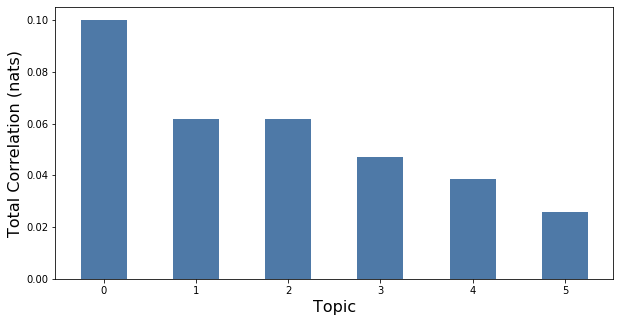

In [115]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [116]:
topic_model.tcs

array([0.10004035, 0.06178414, 0.06158247, 0.04704573, 0.03858756,
       0.02565381])

In [118]:
#anchoring
topic_model = ct.Corex(n_hidden=5, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df.comments, 
                anchors=[['government', 'political'], 
                         ['health', 'economic'], 
                         ['science', 'human'], 
                         ['earth', 'planet'],
                         ['climate']], anchor_strength=2)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: que,la,el,los,es,en,para,una,las,lo
1: cancer,health,patients,doctors,patient,treatment,cells,disease,hiv,drugs
2: co2,ice,carbon,greenhouse,nuclear,plants,water,gas,warming,temperature
3: surah,verse,vostok,quran,al,allah,barnola,lvy8pwx9b74,exwtxb6os6i,omh4og8t_fw
4: refugees,immigration,democracy,refugee,immigrants,asylum,border,country,countries,vote


In [120]:
#force with anchors to get smaller topics
topic_model = ct.Corex(n_hidden=5, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df.comments, 
                anchors=[['virus', 'health'], 'virus'], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: health,virus,cancer,doctors,patients,co2,patient,healthcare,medicine,disease
1: virus,mosquitoes,het,covid,zu,mosquito,viruses,der,und,een
2: refugees,democracy,immigration,immigrants,refugee,country,asylum,countries,border,vote
3: muslim,islam,muslims,prison,prisons,jail,jihad,gaza,bail,justice
4: que,la,el,los,es,en,para,una,las,lo


In [122]:
#use same words in the different topics
#anchors

#women
topic_model = ct.Corex(n_hidden=8, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df.comments, 
                anchors=[['virus'], ['virus'], ['virus'], ['virus']], anchor_strength=5)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: co2,climate,ice,carbon,vostok,greenhouse,nuclear,warming,barnola,temperature
1: que,la,el,es,los,en,para,una,las,het
2: virus,cancer,patients,doctors,disease,cells,patient,health,hiv,treatment
3: refugees,muslim,israel,immigration,muslims,iran,islam,refugee,asylum,immigrants
4: gofund,woww,nursery,needy,microscope,chips,july,rodney,gps,microsoft
5: prison,cyberhackinggenius,prisons,jail,bail,phone,crime,husband,justice,husbands
6: loan,money,bank,homebuilding,rabblehousers,613195517,imf,currency,inflation,debt
7: jacob,nous,je,singing,song,nhung,uoc,et,songs,tien


# Sentiment Analysis Vader

In [123]:
analyser = SentimentIntensityAnalyzer()

In [126]:
analyser.polarity_scores(df['comments'].values[11])

{'neg': 0.067, 'neu': 0.782, 'pos': 0.151, 'compound': 0.9901}

# LDA PyViz

In [127]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             max_features=1000,                # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(df.comments)

In [128]:
n_components = 10

lda_model = LatentDirichletAllocation(n_components=n_components,   # Number of topics
                                      max_iter=10,                 # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,            # Random state
                                      #batch_size=128,             # n docs in each learning iter
                                      n_jobs = -1,                 # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [129]:
pyLDAvis.enable_notebook()

panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer)
panel

/Users/elena/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.053859  0.015955       1        1  24.777800
8     -0.071851 -0.008928       2        1  19.559825
7     -0.071295  0.024468       3        1  14.202735
4     -0.079318  0.041838       4        1  11.950374
5     -0.063053  0.058107       5        1  11.334740
6     -0.070162  0.058874       6        1   6.997485
1     -0.070246  0.098449       7        1   5.394002
3     -0.064671 -0.019688       8        1   4.081690
0      0.472794  0.094732       9        1   0.890047
2      0.071662 -0.363807      10        1   0.811303, topic_info=    Category         Freq     Term        Total  loglift  logprob
152  Default  3761.000000      com  3761.000000  30.0000  30.0000
992  Default  3272.000000      www  3272.000000  29.0000  29.0000
429  Default  3488.000000    https  3488.000000  28.0000  28.0000
426  Default  3429.000000     href  3429.000000  27.0000  27.0000
999  Default  2830.000000  youtube  2830.000000  26.0000  26.0000
..       ...          ...      ...          ...      ...      ...
840  Topic10    26.836698     stop   873.551783   1.3315  -4.6694
552  Topic10    30.062238     make  2100.704394   0.5675  -4.5559
519  Topic10    30.020979     like  5109.653225  -0.3227  -4.5572
517  Topic10    27.654593     life  2087.315433   0.4904  -4.6393
476  Topic10    26.933911     just  4455.323969  -0.2942  -4.6657

[552 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2         1  0.103075     2019
2         2  0.206149     2019
2         4  0.198787     2019
2         5  0.287137     2019
2         6  0.080987     2019
...     ...       ...      ...
999       4  0.031802  youtube
999       5  0.874548  youtube
999       6  0.019081  youtube
999       7  0.003534  youtube
999       8  0.002827  youtube

[2317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 8, 5, 6, 7, 2, 4, 1, 3])

In [84]:
#stemmer=LancasterStemmer()
#porter=PorterStemmer()

In [132]:
englishStemmer=SnowballStemmer("english", ignore_stopwords=True)
def stemComment(comment_line):
    token_words=word_tokenize(comment_line)
    stem_line=[]
    for word in token_words:
        stem_line.append(englishStemmer.stem(word))
        stem_line.append(" ")
    return "".join(stem_line)

In [133]:
stop_words = set(stopwords.words('english'))

def remove_stop_words(comment_line):
    token_words=word_tokenize(str(comment_line))
    filtered_comment_line = [w for w in token_words if not w in stop_words] 
    
    return " ".join(filtered_comment_line)

In [134]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-134-2712561aa3de>:1: DeprecationWarning: invalid escape sequence \w
  alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)


In [137]:
df['comments'] = df['comments'].map(remove_stop_words).map(alphanumeric).map(punc_lower)

In [138]:
#https://stackoverflow.com/questions/29270917/removing-custom-stop-words-form-a-phrase-in-python
my_stop_words_lst = ['ted', 'text', 'thank', 'you']

for w in my_stop_words_lst:
    pattern = r'\b'+w+r'\b'
    custom_stop = lambda x: re.sub(pattern, ' ', x)
    df['comments'] = df['comments'].map(custom_stop)

In [139]:
df['comments'] = df['comments'].map(stemComment)

In [140]:
df.head()

,video_id,comments,spacy_doc
0,-2Dj9M71JAc,she sound like person sing someon accident lef...,"(She, sounds, like, the, person, before, was, ..."
1,-3y6_7_5PcQ,stop fund larg pharmaceut buy overpr product t...,"(Stop, funding, large, pharmaceuticals, by, bu..."
2,-7ORAKULel4,fals technolog still reach peopl i programm i ...,"(False, ,, the, technology, is, still, out, of..."
3,-BvcToPZCLI,what carbon footprint food seem like least gen...,"(What, is, the, carbon, footprint, of, your, f..."
4,-E5K2pGB08Y,full karen stumbl autoplay br super confus int...,"(Full, of, Karens, ., ,, stumbled, here, throu..."


In [142]:
df['comments'][1]

'stop fund larg pharmaceut buy overpr product they feed desper stay aliv mani cure accept rich even cure bellow effect yet privat hospit pharma make seek expens cure don let compani like bayer overtak world let politician decid futur quot million american lost famili member friend quot br br right peopl actual affect way tug heartstr support claim couldn less relev br br quot rise drug cost push famili homeless senior bankruptci parent crowdfund treatment critic ill children quot br br well good thing peopl say afford drug abl take advantag exist healthcar financi handout no one countri homeless unless choos yes make poor decis lead abl leech system anymor as senior they like american make respons financi decis instead reli govern hand social secur check bother save retir br br as far point patent extend beyond limit yes seem wrong take account cost make drug often time approv result hundr million billion dollar loss compani if motiv make drug happen the compani everyon like hate pharm

# Build Document-Term matrix

In [143]:
vectorizer = TfidfVectorizer(stop_words='english') 
doc_word = vectorizer.fit_transform(list(df.comments))
doc_word

<2193x37839 sparse matrix of type '<class 'numpy.float64'>'
	with 427474 stored elements in Compressed Sparse Row format>

In [144]:
pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names()).shape

(2193, 37839)

In [145]:
dtm = pd.DataFrame(doc_word.toarray(), index=df['video_id'], columns=vectorizer.get_feature_names())

# Topic Modeling

In [146]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


### Latent Semantic Analysis (LSA)

In [147]:
lsa = TruncatedSVD(10)
doc_topic = lsa.fit_transform(dtm)
lsa.explained_variance_ratio_

array([0.00547276, 0.00850628, 0.00725554, 0.00564826, 0.00511844,
       0.00433231, 0.00420112, 0.00386647, 0.00348286, 0.00313515])

In [148]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5",
                     "component_6","component_7", "component_8","component_9", "component_10"],
             columns = vectorizer.get_feature_names())
topic_word

aa    aaa   aaaa  aaaaaaa  \
component_1   0.000  0.001  0.000    0.000   
component_2   0.001 -0.001  0.000    0.001   
component_3   0.000  0.001 -0.001    0.000   
component_4   0.001  0.000  0.001    0.001   
component_5   0.001  0.000 -0.001    0.000   
component_6  -0.001  0.002 -0.001    0.000   
component_7  -0.000  0.002 -0.000   -0.000   
component_8  -0.000 -0.002 -0.001    0.000   
component_9  -0.002 -0.001  0.001    0.001   
component_10 -0.000  0.001  0.001   -0.001   

              aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [149]:
display_topics(lsa, vectorizer.get_feature_names(), 15)


Topic  0
br, quot, peopl, like, https, com, talk, www, watch, href, youtub, make, amp, need, think

Topic  1
br, https, com, www, youtub, href, amp, watch, youtu, http, dare, queri, search, result, sleep

Topic  2
com, www, youtub, https, watch, href, amp, quot, talk, http, video, love, amaz, inspir, beauti

Topic  3
women, men, br, woman, love, girl, gender, beauti, femal, male, black, equal, feel, feminist, sexual

Topic  4
women, men, countri, com, www, govern, https, youtub, href, africa, money, peopl, amp, gender, china

Topic  5
cancer, women, doctor, patient, men, medic, health, diseas, cell, cure, brain, treatment, bodi, medicin, vaccin

Topic  6
school, parent, teacher, love, kid, help, educ, africa, peopl, student, children, famili, inspir, beauti, patient

Topic  7
women, earth, water, climat, men, planet, plant, ocean, beauti, africa, citi, inspir, space, ice, human

Topic  8
school, robot, teacher, student, kid, educ, ai, job, parent, teach, learn, women, technolog, car, 

In [62]:
lsa.components_

array([[ 9.68620709e-05,  1.03763392e-04,  7.48935844e-05, ...,
         2.98614931e-05,  5.97229861e-05,  1.11542964e-05],
       [ 1.88035532e-05,  1.64924212e-04,  4.20325867e-03, ...,
         6.46077822e-04,  1.29215564e-03,  2.59712183e-05],
       [ 1.10812732e-03, -5.44983553e-04, -1.47105038e-04, ...,
         1.22011256e-04,  2.44022511e-04, -8.35359701e-05],
       [ 3.75091143e-04,  5.80494082e-05,  3.32403708e-04, ...,
         1.41503516e-04,  2.83007031e-04, -1.28096529e-04],
       [ 2.62605934e-04, -1.35827142e-03,  7.39542845e-04, ...,
        -7.08270320e-04, -1.41654064e-03, -2.02189834e-04]])

In [151]:
doc_topic_lsa = pd.DataFrame(doc_topic,
                             index=df['video_id'],
                             columns = ["component_1","component_2", "component_3","component_4", "component_5", 
                                        "component_6","component_7", "component_8","component_9", "component_10"])
doc_topic_lsa

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
video_id,,,,,,,,,,
-2Dj9M71JAc,0.266000,-0.107908,-0.023621,0.005362,0.094486,-0.085834,0.084017,-0.066206,0.037286,0.036091
-3y6_7_5PcQ,0.409705,-0.011464,-0.125518,-0.109855,0.052816,0.072584,0.009366,-0.125352,-0.046002,-0.077359
-7ORAKULel4,0.192574,-0.040331,-0.025246,-0.057819,-0.029256,-0.019008,-0.066237,-0.027873,0.047925,-0.086902
-BvcToPZCLI,0.196401,0.108696,-0.003085,-0.079764,0.022084,0.014114,-0.093784,0.092012,-0.032064,0.121580
-E5K2pGB08Y,0.078095,0.046325,0.038942,0.013708,-0.016168,-0.016340,0.011026,0.013973,-0.006555,-0.033938
...,...,...,...,...,...,...,...,...,...,...
zpjxElfNpks,0.351525,-0.005470,0.018066,-0.103694,0.115243,-0.080217,0.028173,-0.001939,-0.033765,-0.067635
zpn6MCmoK0g,0.428520,0.092874,-0.018257,0.007788,0.001724,-0.023449,0.035847,0.136572,-0.030291,0.094114
zqLYcJ6Ib3c,0.222388,-0.011191,0.132170,0.037601,-0.051911,-0.035397,0.057208,-0.007793,-0.001798,-0.012000


In [152]:
cosine_similarity((doc_topic_lsa.values[0], 
                   doc_topic_lsa.values[1], 
                   doc_topic_lsa.values[3],  
                   doc_topic_lsa.values[4], 
                   doc_topic_lsa.values[5], 
                   doc_topic_lsa.values[6]))

array([[1.        , 0.72130732, 0.29860118, 0.36162804, 0.71419755,
        0.55677025],
       [0.72130732, 1.        , 0.4890254 , 0.46519637, 0.86788939,
        0.50557138],
       [0.29860118, 0.4890254 , 1.        , 0.45252782, 0.62244494,
        0.48874896],
       [0.36162804, 0.46519637, 0.45252782, 1.        , 0.38345257,
        0.85363818],
       [0.71419755, 0.86788939, 0.62244494, 0.38345257, 1.        ,
        0.48674256],
       [0.55677025, 0.50557138, 0.48874896, 0.85363818, 0.48674256,
        1.        ]])

In [109]:
#cosine_similarity((doc_topic_lsa.values[0], doc_topic_lsa.values[6]))

### NMF (Non-Negative Matrix Factorization)

In [153]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_word)

In [154]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5"],
             columns = vectorizer.get_feature_names())
topic_word

aa    aaa   aaaa  aaaaaaa  \
component_1  0.000  0.002  0.000    0.000   
component_2  0.002  0.000  0.000    0.001   
component_3  0.000  0.000  0.002    0.001   
component_4  0.001  0.001  0.000    0.001   
component_5  0.000  0.002  0.000    0.000   

             aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [156]:
display_topics(nmf_model, vectorizer.get_feature_names(), 14)


Topic  0
quot, talk, love, like, peopl, beauti, video, think, life, amaz, know, feel, great, realli

Topic  1
com, https, www, youtub, href, watch, amp, http, youtu, queri, search, result, video, br

Topic  2
br, dare, quot, youtu, human, life, god, https, natur, make, scienc, water, earth, creat

Topic  3
women, men, woman, gender, equal, male, girl, femal, feminist, black, peopl, sexual, quot, children

Topic  4
peopl, countri, quot, money, govern, need, world, problem, work, chang, live, use, africa, make


In [157]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             index=df['video_id'],
                             columns = ["component_1","component_2", "component_3","component_4", "component_5"])
doc_topic_nmf

,component_1,component_2,component_3,component_4,component_5
video_id,,,,,
-2Dj9M71JAc,0.02124,0.00813,0.01800,0.04271,0.08321
-3y6_7_5PcQ,0.00925,0.02256,0.08504,0.00000,0.13981
-7ORAKULel4,0.03305,0.00019,0.02852,0.00000,0.04571
-BvcToPZCLI,0.00309,0.05839,0.04681,0.00000,0.03916
-E5K2pGB08Y,0.01608,0.03126,0.01248,0.00000,0.00000
...,...,...,...,...,...
zpjxElfNpks,0.01324,0.06095,0.03297,0.00000,0.12132
zpn6MCmoK0g,0.05056,0.07280,0.09208,0.02043,0.05785
zqLYcJ6Ib3c,0.07810,0.05244,0.00149,0.00000,0.00000


In [158]:
cosine_similarity((doc_topic_nmf.values[0], doc_topic_nmf.values[1]))

array([[1.        , 0.83598339],
       [0.83598339, 1.        ]])

In [159]:
cosine_similarity((doc_topic_nmf.values[0], doc_topic_nmf.values[26]))

array([[1.        , 0.33662272],
       [0.33662272, 1.        ]])

### LDA

Changing vectorizer from TF-IDF

In [160]:
vectorizer = CountVectorizer(stop_words='english') 
doc_word = vectorizer.fit_transform(list(df.comments))
doc_word

<2193x37839 sparse matrix of type '<class 'numpy.int64'>'
	with 427474 stored elements in Compressed Sparse Row format>

In [161]:
pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names()).shape

(2193, 37839)

In [162]:
dtm = pd.DataFrame(doc_word.toarray(), index=df['video_id'], columns=vectorizer.get_feature_names())

In [163]:
lda = LatentDirichletAllocation(n_components=5)

In [164]:
doc_topic = lda.fit_transform(dtm)


In [165]:
lda.score

<bound method LatentDirichletAllocation.score of LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)>

In [166]:
topic_word = pd.DataFrame(lda.components_.round(3),
             index = ["component_1","component_2", "component_3","component_4", "component_5"],
             columns = vectorizer.get_feature_names())
topic_word

aa    aaa  aaaa  aaaaaaa  \
component_1  1.200  1.517   1.2      0.2   
component_2  0.200  0.200   0.2      0.2   
component_3  0.200  0.200   0.2      0.2   
component_4  2.191  2.800   0.2      1.2   
component_5  0.209  0.283   0.2      0.2   

             aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [167]:
display_topics(lda, vectorizer.get_feature_names(), 15)


Topic  0
br, peopl, com, href, www, quot, https, like, youtub, talk, world, need, http, work, make

Topic  1
br, year, ice, peopl, quot, like, chang, al, climat, school, need, good, work, make, way

Topic  2
br, que, la, peopl, use, el, quot, es, need, en, citi, los, car, nuclear, year

Topic  3
br, quot, like, peopl, watch, https, com, talk, href, www, youtub, amp, make, think, know

Topic  4
quot, br, peopl, like, talk, make, women, want, need, know, work, think, world, good, say


In [168]:
lda.components_

array([[1.20007793, 1.5173092 , 1.1999977 , ..., 0.20000036, 1.19836438,
        1.19836438],
       [0.20000175, 0.2000038 , 0.20000088, ..., 0.20000086, 0.20000104,
        0.20000104],
       [0.20000201, 0.2000043 , 0.20000105, ..., 0.200001  , 0.20000125,
        0.20000125],
       [2.1910491 , 2.79962063, 0.20000013, ..., 0.20000012, 0.20163305,
        0.20163305],
       [0.20886921, 0.28306207, 0.20000024, ..., 1.19999766, 0.20000027,
        0.20000027]])

In [169]:
doc_topic_lda = pd.DataFrame(doc_topic.round(5),
                             index=df['video_id'],
                             columns = ["component_1","component_2", "component_3","component_4", "component_5"])
doc_topic_lda

,component_1,component_2,component_3,component_4,component_5
video_id,,,,,
-2Dj9M71JAc,0.36940,0.00063,0.01669,0.00064,0.61264
-3y6_7_5PcQ,0.04405,0.00041,0.03813,0.41449,0.50292
-7ORAKULel4,0.00098,0.00097,0.00097,0.83275,0.16433
-BvcToPZCLI,0.00012,0.07241,0.00012,0.56244,0.36491
-E5K2pGB08Y,0.99170,0.00206,0.00206,0.00210,0.00208
...,...,...,...,...,...
zpjxElfNpks,0.66484,0.00060,0.00059,0.29929,0.03468
zpn6MCmoK0g,0.00048,0.00047,0.00047,0.90477,0.09380
zqLYcJ6Ib3c,0.00110,0.00109,0.00109,0.99560,0.00111


In [170]:
cosine_similarity((doc_topic_nmf.values[0], doc_topic_nmf.values[1]))

array([[1.        , 0.83598339],
       [0.83598339, 1.        ]])

In [171]:
cosine_similarity((doc_topic_nmf.values[0], doc_topic_nmf.values[136]))

array([[1.        , 0.85207428],
       [0.85207428, 1.        ]])